## Project Food recognition
A.Y. 2020/2021

|  Surname | Name   | Matricola   | Accademic Mail   |
|---|---|---|---|
|Seroyizhko   | Pavlo     |  982598   | pavlo.seroyizhko@studio.unibo.it |
|Wen          | Xiaowei   | 982501  | xiaowei.wen@studio.unibo.it  |

# Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
# PAVLO
# %cd drive/MyDrive/food_recognition_project/

# WEN
%cd drive/MyDrive/UNIBO/FirstYear/SecondSemester/Deeplearning/food_recognition_project/

Mounted at /content/drive
/content/drive/MyDrive/UNIBO/FirstYear/SecondSemester/Deeplearning/food_recognition_project


# Importing libraries & Configuring environment



In [1]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
from TiramisuNet import TiramisuNet
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.patches as mpatches
import tensorflow as tf
from keras import backend as K
import pandas as pd
from IPython.display import display, HTML
%matplotlib inline
import os
os.environ['SM_FRAMEWORK'] = "tf.keras"

!pip install -U segmentation-models # if running in local machine, execute this line in the terminal and comment it here. 
import segmentation_models as sm
sm.set_framework("tf.keras")
import pandas as pd
import threading

ERROR: Invalid requirement: '#'


Segmentation Models: using `tf.keras` framework.


# Generators


In [2]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return None

def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img
    


"""
input 
    imageObj: dict - Coco image annotaion
    coco: Coco() - Coco object
    catIDs: list - list of categories ids
    catAllias : list - list of dict of format {categoriId: id_of_class}
    input_image_size: tuple - desired image size (width, height)
    
output
    masks: array - (width, height, n_cat) where n_cat is number of cotegories that are on the photo
    cats: list - list of id assocciated with categories id taken from catAllias
    

"""

def getMasksWithCats(imageObj, coco, catIDs, catAllias, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIDs, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = []
    masks = np.zeros(input_image_size)
    for a in range(len(anns)):
        ann = anns[a]
        cat_value = catAllias.loc[catAllias['cat_id'] == ann['category_id']]['class_id'].values[0]
        new_mask = cv2.resize(coco.annToMask(ann)*cat_value, input_image_size)
        masks = np.maximum(new_mask, masks)
        if cat_value != 0:
            cats.append(cat_value)


    masks = np.rint(masks)
    vals, count = np.unique(masks, return_counts=True)
    vals = vals[count<100]
    mm = np.isin(masks, vals)

    masks[mm] = 0

    return masks.reshape(input_image_size + (1,)), cats
    

def maskToNChannelMask(mask2d, cats, n_channels):
    output = np.zeros((mask2d.shape + (n_classes,))).astype('float')
    output[:,:,0] = 1.0
    
    for cat_value in cats:
        n_mask = np.zeros(mask2d.shape).astype('float')
        n_mask[mask2d==cat_value] = 1.0
        output[:,:,cat_value] = n_mask
        output[:,:,0] -= n_mask

    
    output[output[:,:,0] < 0] = 0

    return output

"""
input

    coco: COCO() - A COCO class with annotions of desired dataset
    images: lsit - list of images obtained from COCO.loadImgs()
    folder: String - root folder with coco images
    input_image_size: tuple - desired image size (width, height)
    catAllias : list - list of dict of format {categoriId: id_of_class}
    mode: String - "train" | "val" | "test"
    batch_size: Int - number of augmented images on output after calling next()
    
output

    python generator function
    

    the function is a python generator function which on calling next() will return
    
    X: array of augmented images of size (batch_size, n, m, 3), where n is width and m is height
    y: array of equally augmented masks of size (batch_size, n, m, n_classes), 
            array will be 0 for all the 4th dimensions that are not the id number of the category
            
    every batch is generated by 1 image on which is going to be applied the keras Image Generator

"""

def cocoDataGenerator(coco, images, folder, input_image_size, catAllias, mode='train', batch_size=16):
    # coco parameters
    c = 0 # index of desired image that will generate the batch
    img_folder = '{}/images/{}'.format(folder, mode)
    dataset_size = len(images)
    #catIds = coco.getCatIds()
    n_classes = len(catAllias)
    random.shuffle(images)
    lock = threading.Lock()
    
    catIds = catAllias['cat_id'].values.tolist()[1:]
    
    while(True):
        with lock:
            img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
            mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], n_classes)).astype('float')

            for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
                imageObj = images[i]

                ### Retrieve Image ###
                train_img = getImage(imageObj, img_folder, input_image_size)

                im_masks, im_cats = getMasksWithCats(imageObj, coco, catIds, catAllias, input_image_size) 
                train_mask = maskToNChannelMask(im_masks[:,:,0], im_cats, n_classes)
                
                img[i-c] = train_img
                mask[i-c] = train_mask
                
             

            c+=batch_size
            if(c + batch_size >= dataset_size):
                c=0
                random.shuffle(images)
                
        # visuallize images and masks
        # for bbb in range(batch_size):
        #   plt.subplot(121)
        #   plt.imshow(img[bbb])
        #   plt.subplot(122)
        #   visuallizeMaskWithLabels(mask[bbb], cats, cat_allias)
        yield img, mask
        
        
def cocoDataGeneratorWithAugBalanced(coco, images, folder, input_image_size, cat_alliasDf, mode='train', batch_size=16):
    
    #aug parameters
    seed = 32
    augGeneratorArgs = dict(featurewise_center = False, 
                        samplewise_center = False,
                        rotation_range = 5, 
                        width_shift_range = 0.01, 
                        height_shift_range = 0.01, 
                        brightness_range = (0.8,1.2),
                        shear_range = 0.01,
                        zoom_range = [1, 1.25],  
                        horizontal_flip = True, 
                        vertical_flip = True,
                        fill_mode = 'reflect',
                        data_format = 'channels_last') # the arguments used by keras ImageGenerator for images
    
    augGeneratorArgs_mask = augGeneratorArgs.copy()
    _ = augGeneratorArgs_mask.pop('brightness_range', None) # the arguments used by keras ImageGenerator for mask (same but without brightness)


    # Initialize the mask data generator with modified args
    image_gen = ImageDataGenerator(**augGeneratorArgs)
    mask_gen = ImageDataGenerator(**augGeneratorArgs_mask)
    
    np.random.seed(seed) # to avoid randomness between image and masks
    
    # coco parameters
    idx = 0 # index of desired image that will generate the batch
    idx_full = 0
    
    img_folder = '{}/images/{}'.format(folder, mode)
    
    filterClasses = cat_alliasDf['cat_name'].values.tolist()
    #catIDs = np.sort(coco.getCatIds(catNms=filterClasses))

    dataset_size = len(images)
    n_classes = cat_alliasDf.iloc[-1]['class_id'] + 1

    n_images_per_class = cat_alliasDf.iloc[1]['n_images']
    full_circle =  n_classes*n_images_per_class
    catIds = cat_alliasDf['cat_id'].values.tolist()[1:]

    images_per_class_to_do = np.ones(n_classes)*n_images_per_class
    images_per_class_to_do[0] = 0
    random.shuffle(images)
    # infinite loop is required by keras model
    print(f"Generating {n_classes-1} classes with {n_images_per_class} images each")
    while(True):       

        imageObj = images[idx]

        #getMasksWithCats return array of masks for each category on the image and a list of squeezed categories 
        im_masks, im_cats = getMasksWithCats(imageObj, coco, catIds, cat_alliasDf, input_image_size) 
        n_masks = im_masks.shape[2]
    
        orig_num_of_imgs = cat_alliasDf[alliasDf['class_id'].isin(im_cats)]['n_images'].values
        
        im_cats_no_dubl = list(dict.fromkeys(im_cats))
        
        batch_start = 1
        
        if ((n_images_per_class - images_per_class_to_do[im_cats_no_dubl]) > orig_num_of_imgs).any():
            batch_start = 0
        #  output
        X = np.zeros((batch_size, input_image_size[0], input_image_size[1],3)).astype('float')
        y = np.zeros((batch_size, input_image_size[0], input_image_size[1],n_classes)).astype('float')
        
        if len(im_cats)>0 and (images_per_class_to_do[im_cats_no_dubl] > 0).any():
            
            img = getImage(imageObj, img_folder, input_image_size) #image_array
            if batch_start == 1:
                train_mask = maskToNChannelMask(im_masks[:,:,0], im_cats, n_classes)

                X[0] = img
                y[0] = train_mask

            seed = np.random.choice(range(9999))
            # keep the seeds syncronized otherwise the augmentation of the images 
            # will end up different from the augmentation of the masks

            # image generator
            g_x = image_gen.flow(img.reshape((1,)+img.shape), 
                                 batch_size = batch_size, 
                                 seed = seed)

            # masks generators
            g_ys = mask_gen.flow(im_masks.reshape((1,)+im_masks.shape), 
                                 batch_size = batch_size, 
                                 seed = seed)

            for batch_num in range(batch_start, batch_size):
                next_aug = g_x.next()/255.0
                next_aug_mask = g_ys.next()[0,:,:,0]

                vals, count = np.unique(next_aug_mask, return_counts=True)
                vals = vals[count<100]
                #print(vals)
                #print(count)
                mm = np.isin(next_aug_mask, vals)

                next_aug_mask[mm] = 0

                X[batch_num] = next_aug
                y[batch_num] = maskToNChannelMask(next_aug_mask, im_cats, n_classes)


            images_per_class_to_do[im_cats_no_dubl] -= 1

            if np.sum(images_per_class_to_do) <= 0:
                images_per_class_to_do = np.ones(n_classes)*n_images_per_class
                images_per_class_to_do[0] = 0

            yield X, y
        
        if idx_full >= full_circle-1:
          images_per_class_to_do = np.ones(n_classes)*n_images_per_class
          images_per_class_to_do[0] = 0
          idx_full = 0
        else:
          idx_full += 1
            
        if idx >= dataset_size-1:
            idx = 0
            random.shuffle(images)
        else:
            idx += 1


def collectImagesByClasses(coco, filterClasses):
    images = []
    if filterClasses!=None:
        # iterate for each individual class in the list
        for className in filterClasses:
            # get all images containing given class
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)

    # Now, filter out the repeated images    
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])

    return unique_images

def createCatAlliasDF(coco, n, classesToIgnore):
    catsIds = coco.getCatIds()
    cats = coco.loadCats(catsIds)
    annIds = coco.getAnnIds()
    anns = coco.loadAnns(annIds)
    cat_freq = []
    while anns:
        cat = anns[0]['category_id']
        if not (getClassName(cat, cats) in classesToIgnore):
            f = 0
            for ann in anns:
                if ann['category_id'] == cat:
                    f += 1

            cat_freq.append({"cat_id":cat, "freq": f})

        anns = [x for x in anns if x['category_id'] != cat]
        
    
    cat_freq = sorted(cat_freq, key=lambda k: k["freq"], reverse=True)
    cat_freq = cat_freq[0:n]
    cat_names = ['background']
    cat_ids = [0]
    freqs = [0]
    for c in cat_freq:
        cat_names.append(getClassName(c["cat_id"], cats))
        cat_ids.append(c["cat_id"])
        freqs.append(c["freq"])
    df = pd.DataFrame({'cat_name': cat_names, 'cat_id': cat_ids, 'class_id': range(0,n+1), 'n_images': freqs})
    display(HTML(df.to_html()))
    return df

def nClassSegmantationToArray(mask, channelsToIgnore=[]):
    output = np.zeros((mask.shape[0], mask.shape[1]))
    for i in range(mask.shape[2]):
        if len(np.unique(mask[:,:,i])) > 1 and i not in channelsToIgnore:
            #print(f"{i}: {np.unique(mask[:,:,i])}")
            output = np.maximum(output, mask[:,:,i]*i)
    return output    

def visuallizeMaskWithLabels(mask, catAllias):
    mask = np.rint(mask)
    if mask.shape[2] == 1: 
        mask = mask[:,:,0]
    elif mask.shape[2] > 1:
        mask = nClassSegmantationToArray(mask)

    
    values = np.unique(mask)
    im = plt.imshow(mask)
    colors = [ im.cmap(im.norm(value)) for value in values]
    # create a patch (proxy artist) for every color 
    patches = [ mpatches.Patch(color=colors[i], label=catAllias.loc[catAllias['class_id']==values[i]]['cat_name'].values) for i in range(len(values)) ]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    plt.show()
    
def visuallizePrediction(img, mask, catAllias, title, classesToIgnore=[], minPixls=100):
    mask = np.rint(mask)
    if mask.shape[2] == 1: 
        mask = mask[:,:,0]
    elif mask.shape[2] > 1:
        mask = filterPerNPixels(mask, minPixls)
        mask = nClassSegmantationToArray(mask, classesToIgnore)
    
    values = np.unique(mask)
    values = values[1:]
    mask[mask==0] = np.nan
    
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.set_title(title)
    ax1.imshow(img)
    
    ax2.imshow(img)
    im = ax2.imshow(mask, alpha=0.4)
    
    colors = [ im.cmap(im.norm(value)) for value in values if value != np.nan]
    # create a patch (proxy artist) for every color 
    patches = [ mpatches.Patch(color=colors[i], label=catAllias.loc[catAllias['class_id']==values[i]]['cat_name'].values) for i in range(len(values)) ]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    plt.show()
    
    
def filterPerNPixels(mask, minPxls=100):
    vals, count = np.unique(mask, return_counts=True)
    vals = vals[count<minPxls]
    mm = np.isin(mask, vals)
    mask[mm] = 0
    return mask

# Data Forming

In [3]:
coco_train=COCO("annotations/train.json")
coco_val=COCO("annotations/val.json")
coco_test = COCO("annotations/test.json")

loading annotations into memory...
Done (t=2.84s)
creating index...
index created!
loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


In [4]:
alliasDf = createCatAlliasDF(coco_train, 16, classesToIgnore=["coffee-with-caffeine", "espresso-with-caffeine"])
filterClasses = alliasDf['cat_name'].values.tolist()[1:]
cats = coco_train.getCatIds()
images_train = collectImagesByClasses(coco_train, filterClasses)
images_val = collectImagesByClasses(coco_val, filterClasses)
images_test = collectImagesByClasses(coco_test, filterClasses)


imgs_size = (192,192)
n_train_imgs = len(images_train)
n_val_imgs = len(images_val)
n_classes = alliasDf.iloc[-1]['class_id']  + 1
batch_size = 8
steps_per_epoch = len(images_train)//batch_size
# steps_per_epoch = n_classes * alliasDf.iloc[1]['n_images']

,cat_name,cat_id,class_id,n_images
0,background,0,0,0
1,water,2578,1,1837
2,bread-white,1566,2,1276
3,salad-leaf-salad-green,1040,3,1190
4,tomato,1069,4,1072
5,butter,2053,5,1010
6,bread-wholemeal,1565,6,905
7,carrot,1078,7,898
8,rice,1468,8,659
9,egg,2022,9,632


In [5]:
dg_train = cocoDataGeneratorWithAugBalanced(coco_train, images_train, os.getcwd(), imgs_size, alliasDf, batch_size=batch_size)
dg_val = cocoDataGenerator(coco_val, images_val, os.getcwd(), imgs_size, alliasDf, mode = "val", batch_size=batch_size)
dg_test = cocoDataGenerator(coco_test, images_test, os.getcwd(), imgs_size, alliasDf, mode = "test", batch_size=batch_size)

In [6]:
from IPython.display import clear_output

def show_predictions():
    result = model.predict(sample_image)
    thr = 1/17
    result[result>=thr] = 1.0
    result[result<thr] = 0.0
    visuallizePrediction(sample_image[0], result[0], alliasDf, title="50 epochs", minPixls=100)


class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print('\nSample Prediction after epoch {}\n'.format(epoch + 1))


In [7]:
sample_image, sample_mask = next(dg_test) # instantiating an image as the sample to be displayed at the end of each epoch


# Model Creation

## loading all models with pre-trained weights

In [ ]:
model_weights = ["food_recognition_focal_loss_no_aug.h5",
                 "food_recognition_focal_loss_no_aug_100epochs.h5",
                 "food_recognition_focal_loss_no_aug_75epochs.h5",
                 "food_recognition_focal_loss_aug_50epochs.h5",
                 "food_recognition_focal_loss_aug_75epochs.h5"]

models = []
for file_name in model_weights:
  model = TiramisuNet(input_shape=imgs_size + (3,), n_classes=n_classes)
  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                  loss = sm.losses.categorical_focal_loss,
                  metrics=[sm.metrics.iou_score,
                            tf.keras.metrics.MeanIoU(num_classes=n_classes)])
  model.load_weights(file_name)
  models.append(model)


## Using a model

In [8]:
model = TiramisuNet(
    input_shape=imgs_size + (3,)
    , n_classes=n_classes
  )
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                loss = sm.losses.categorical_focal_loss,
                metrics=[sm.metrics.iou_score,
                          tf.keras.metrics.MeanIoU(num_classes=n_classes)],)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 192, 48) 1344        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 192, 192, 48) 192         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 192, 192, 48) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
weight_to_load = "food_recognition_focal_loss_no_aug.h5"
model.load_weights(weight_to_load)

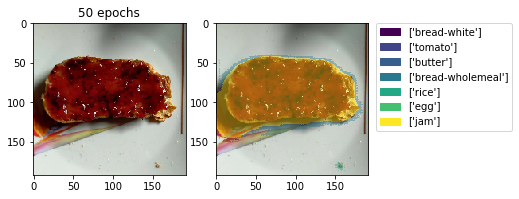

In [10]:
sample_image, sample_mask = next(dg_test)
show_predictions()

# Training

In [ ]:
history = model.fit(x = dg_train
              , validation_data = dg_val
              , validation_steps = n_val_imgs//batch_size
              , steps_per_epoch = steps_per_epoch
              , epochs = 75
              , workers = 1
              , verbose = True
              , callbacks=[DisplayCallback()]
              )

In [ ]:
print(history.history.keys())

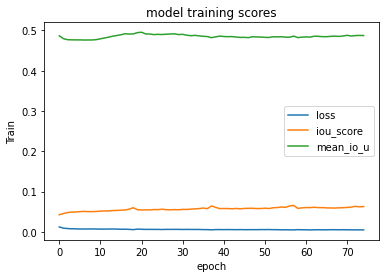

In [ ]:
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['iou_score'])
plt.plot(history.history['mean_io_u'])
plt.title('model training scores')
plt.ylabel('Train')
plt.xlabel('epoch')
plt.legend(['loss', 'iou_score','mean_io_u'], loc='center right')
plt.show()

dict_keys(['loss', 'iou_score', 'mean_io_u', 'val_loss', 'val_iou_score', 'val_mean_io_u'])


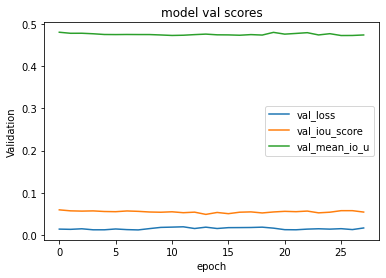

In [ ]:

# summarize history for accuracy
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_iou_score'])
plt.plot(history.history['val_mean_io_u'])
plt.title('model val scores')
plt.ylabel('Validation')
plt.xlabel('epoch')
plt.legend(['val_loss', 'val_iou_score','val_mean_io_u'], loc='center right')
plt.show()

In [ ]:
print( f"argmax ={np.argmax(history.history['val_mean_io_u'])}")
history.history["val_mean_io_u_2"][np.argmax(history.history['val_mean_io_u'])]

argmax =28


0.5421110987663269

In [ ]:
name_weights = ""
model.save_weights(name_weights)

# Results visualization


## Single image visualization

In [ ]:
sample_image, sample_mask = next(dg_test)
result = model.predict(sample_image)
show_predictions()
m = tf.keras.metrics.MeanIoU(num_classes=n_classes+1)
thr = 1/17
result[result>=thr] = 1.0
result[result<thr] = 0.0
m.update_state(sample_mask,result)
iou = np.round(m.result().numpy(), decimals=2)
print(f"mean IoU is {iou}")

## Computing metrics across several images of test data set

In [23]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def compute_mean_iou_per_image(models,mious,dataset=None, num=1):
   m = tf.keras.metrics.MeanIoU(num_classes=n_classes+1)
   for i in  range(len(models)):
      model = models[i]
      result = model.predict(sample_image)
      thr = 1/17
      result[result>=thr] = 1.0
      result[result<thr] = 0.0
      result = tf.cast(result, dtype=tf.float64)
      m.reset_state()
      m.update_state(sample_mask,result)
      iou = np.round(m.result().numpy(), decimals=2)
      mious[i].append(iou)
      precisions[i].append(precision_m(sample_mask,result))
      recalls[i].append(recall_m(sample_mask,result))

In [ ]:
model_names = ["model A","model B","model C","model D","model E"]

mious = []
precisions=[]
recalls =[]
for i in range (len(models)):
  mious.append([])
  precisions.append([])
  recalls.append([])
i = 0
for sample_image, sample_mask in dg_test:
  compute_mean_iou_per_image(models, mious)
  i+=1
  if not i<=458:
    break


In [27]:
f1_score = (2 * m_pre * m_recalls) /(m_pre + m_recalls)
m_iou = np.mean(mious, axis=-1)
m_pre = np.mean(precisions, axis=-1)
m_recalls = np.mean(recalls, axis=-1)
for i in range(len(models)):
  print(f"Model with {model_names[i]} has mean IoU = {m_iou[i]:.2f}, precision={m_pre[i]:.2f}, recall = {m_recalls[i]:.2f}, and f1-score={f1_score[i]:.2f}")

Model with model A has mean IoU = 0.73, precision=0.54, recall = 0.94, and f1-score=0.68
Model with model B has mean IoU = 0.75, precision=0.57, recall = 0.93, and f1-score=0.70
Model with model C has mean IoU = 0.71, precision=0.50, recall = 0.89, and f1-score=0.64
Model with model D has mean IoU = 0.75, precision=0.62, recall = 0.80, and f1-score=0.70
Model with model E has mean IoU = 0.71, precision=0.54, recall = 0.78, and f1-score=0.64
